<a href="https://colab.research.google.com/github/yashvivaghela04/IMAGE-SIMILARITY-SEARCH-/blob/main/ResNet50_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Jee adv maths', 'Jee adv chem', "Certi's", 'Daksh', 'BB', 'Untitled document.gdoc', 'Offer letter ', 'Colab Notebooks', 'Photo album.gslides', 'Untitled presentation.gslides', 'Next 24 tech internship ', 'Satellite Imagery project', 'Documentation.gdoc', 'Documentation for the Assignment.gdoc', 'Jwellery data set.zip', '011_012.png', 'Documentation for Image Similarity Task Using Vision Transformer (ViT).gdoc']
Archive:  /content/drive/MyDrive/Jwellery data set.zip
  inflating: /content/dataset/.gitattributes  
  inflating: /content/dataset/LICENSE  
  inflating: /content/dataset/README.md  
  inflating: /content/dataset/data/RingFIR/001/001_001.png  
  inflating: /content/dataset/data/RingFIR/001/001_002.png  
  inflating: /content/dataset/data/RingFIR/001/001_003.png  
  inflating: /content/dataset/data/RingFIR/001/001_004.png  
  inflating: /content/data

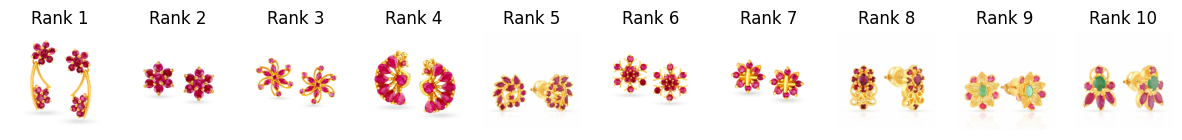

In [6]:
# Mount Google Drive and Extract Dataset
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# List the files in your Google Drive
drive_folder = "/content/drive/MyDrive"
files = os.listdir(drive_folder)
print(files)

# Extract the ZIP file (update with correct path)
zip_file_path = "/content/drive/MyDrive/Jwellery data set.zip"
extraction_path = "/content/dataset"
!unzip -o "$zip_file_path" -d "$extraction_path"

# Verify the extraction
!ls /content/dataset

# Step 1: Get All Image Paths from Subfolders
def get_all_image_paths(folder_path):
    valid_extensions = ('.png', '.jpg', '.jpeg')
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(valid_extensions):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Define the path to the RingFIR folder
dataset_folder = "/content/dataset/data/RingFIR"

# Extract all image paths
image_paths = get_all_image_paths(dataset_folder)
print(f"Extraction complete! Number of extracted images: {len(image_paths)}")

# Install Required Libraries
!pip install transformers faiss-cpu torch torchvision opencv-python-headless numpy

# Import Libraries
import cv2
import torch
import faiss
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and Preprocess Image
def load_and_preprocess_image(input_image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(input_image).convert("RGB")
    return preprocess(image).unsqueeze(0)

# Extract Embeddings
def extract_embeddings(input_image, model):
    preprocessed_image = load_and_preprocess_image(input_image)
    with torch.no_grad():
        outputs = model(preprocessed_image)
        embeddings = outputs.squeeze().numpy()
        embeddings = embeddings.reshape(-1)  # Flatten to 1D array
    return embeddings / np.linalg.norm(embeddings)

# Build FAISS Index
def build_faiss_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

# Find Similar Images
def find_similar_images(input_embedding, index, k=10):
    distances, indices = index.search(np.expand_dims(input_embedding, axis=0), k)
    return distances, indices

# Visualize Top-k Similar Images
def display_images(image_paths):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Rank {i + 1}")
    plt.show()

# Main Function
def main():
    input_image_path = "/content/dataset/data/RingFIR/046/046_012.png"
    top_k = 10
    dataset_path = "/content/dataset/data/RingFIR/046"

    if not os.path.exists(input_image_path):
        raise FileNotFoundError(f"Input image not found: {input_image_path}")
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset folder not found: {dataset_path}")

    # Load ResNet50 Model
    model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove final classification layer
    model.eval()

    # Get Images from Dataset
    dataset_images = [
        os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))
    ]

    if not dataset_images:
        raise ValueError(f"No valid images found in folder: {dataset_path}")

    print(f"Valid images found: {dataset_images}")

    # Extract Embeddings for Dataset Images
    print("Extracting embeddings for database images...")
    db_embeddings = np.vstack([extract_embeddings(img, model) for img in dataset_images])

    # Build FAISS Index
    print("Building FAISS index...")
    faiss_index = build_faiss_index(db_embeddings)

    # Extract Embedding for Input Image
    print(f"Extracting embedding for input image: {input_image_path}")
    input_embedding = extract_embeddings(input_image_path, model)

    # Find Similar Images
    print("Finding similar images...")
    distances, indices = find_similar_images(input_embedding, faiss_index, top_k)

    # Get Top-k Similar Images
    similar_images = [dataset_images[idx] for idx in indices[0]]
    print(f"Top {top_k} similar images:", similar_images)

    # Display Similar Images
    display_images(similar_images)

    return similar_images

# Run Main Function
if __name__ == "__main__":
    top_similar_images = main()
